In [1]:
import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import load_model as tf_load

import cv2
import os 
import sys
sys.path.append("./utils/")
# from slp_utils import posture_tracker
from load_matlab_data import loadmat_sbx
from triangulation_utils import unDistortPoints, camera_matrix, triangulate_confThresh_lowestErr

sys.path.append(".//camera_calibration/")
from pySBA import unconvertParams, PySBA

In [2]:
ds_fac = 4
nCams = 4
nCOMs = 3

In [11]:
root_dir = "Z:/Isabel/data/"
vid_root = f"{root_dir}behavior/SLV124/SLV124_240906/"
save_file = f'240909_posture_2stage.npy'
save_path = f"{vid_root}{save_file}"

In [12]:
# camera params
cam_param_dir = ".//calibration_files/all_opt_arrays/"
cam_param_file = "240903_aligned_opt_cam_array.mat" # UPDATE if-needed to match session
camParams = loadmat_sbx(f"{cam_param_dir}{cam_param_file}")['optCamArray']

.//calibration_files/all_opt_arrays/240903_aligned_opt_cam_array.mat


In [13]:
cameraDicts = []
cameraMats = []
for nCam in range(nCams):
    theseParams = unconvertParams(camParams[nCam])
    cameraDicts.append(theseParams)
    cameraMats.append(camera_matrix(theseParams['K'], theseParams['R'], theseParams['t'].reshape((1,3))))
sba = PySBA(camParams, np.NaN, np.NaN, np.NaN, np.NaN)

In [14]:
all_results = np.load(save_path, allow_pickle=True)
results_dict = all_results.item()

In [15]:
results_dict.keys()

dict_keys(['results', 'camNames', 'session', 'start_frame', 'n_frames', 'cam_params'])

In [16]:
results = results_dict['results']
results.keys()

dict_keys(['posture_preds', 'posture_rep_err', 'posture_rawpred', 'com_preds', 'com_rep_err', 'com_conf', 'posture_conf', 'read_status'])

In [17]:
posture_rep_err = results['posture_rep_err']
posture_conf = results['posture_conf']
posture_preds = results['posture_preds']

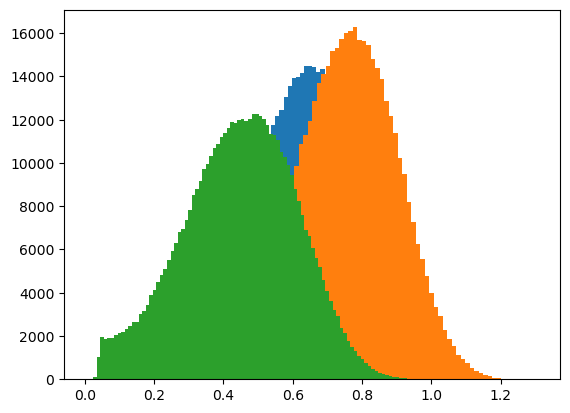

In [30]:
plt.hist(posture_conf[:, 0], bins=100)
plt.hist(posture_conf[:, 14], bins=100)
plt.hist(posture_conf[:, 6], bins=100)

plt.show()

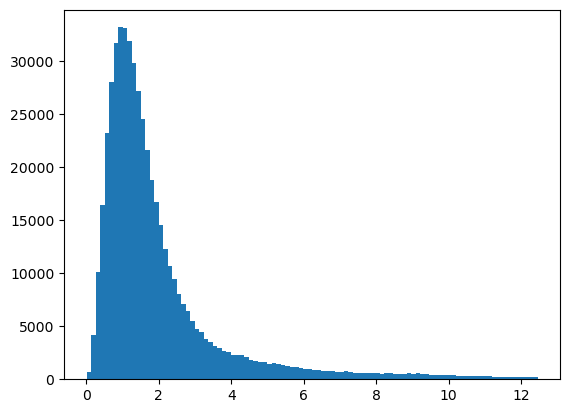

In [29]:
import matplotlib.pyplot as plt

pct99 = np.percentile(posture_rep_err, 99, axis=0)

plt.hist(posture_rep_err[posture_rep_err[:, 0] < pct99[0], 0], bins=100)
plt.hist(posture_rep_err[posture_rep_err[:, 14] < pct99[14], 14], bins=100)
plt.hist(posture_rep_err[posture_rep_err[:, 6] < pct99[6], 6], bins=100)

plt.show()

In [7]:
slp_out = results_dict['results']['raw_preds']
preds = slp_out[0]

In [22]:
nFrames = len(slp_out)

In [17]:
# preallocate results lists (all frames)
comPred = []
comReproj = []
comConf = []

# preallocate results variables (each frame)
best_com = np.full((nCOMs, 3), np.NaN)
com_reproj = np.full((nCOMs), np.NaN)
com_conf = np.full((nCOMs), np.NaN)

In [18]:
for f in range(len(slp_out)):
    preds = slp_out[f]  
    COM = np.squeeze(preds['instance_peaks']) * ds_fac # node locations, shape (n_cams, n_keypoints, 2)
    conf = np.squeeze(preds['instance_peak_vals']) # confidence scores, shape (n_cams, n_keypoints)
    
    # undistort com for each camera
    for nCam in range(nCams):
        COM[nCam] = unDistortPoints(COM[nCam], cameraDicts[nCam]['K'], cameraDicts[nCam]['d'])
        
    # triangulate all COM keypoints, select best triplet and its reprojection error
    for nCom in range(nCOMs):
        com_results = triangulate_confThresh_lowestErr(COM[:, nCom],
                                                    cameraMats,
                                                    conf[:, nCom])
        best_com[nCom], com_reproj[nCom], com_conf[nCom] = com_results

    # collect COM results
    comPred.append(best_com.copy())
    comReproj.append(com_reproj.copy())
    comConf.append(com_conf.copy())

In [25]:
all_reproj = np.stack(comReproj)
all_conf = np.stack(comConf)

In [21]:
com_conf

array([0.72126943, 0.79431087, 0.6380586 ])

In [8]:
COM = np.squeeze(preds['instance_peaks']) * ds_fac # node locations, shape (n_cams, n_keypoints, 2)
conf = np.squeeze(preds['instance_peak_vals']) # confidence scores, shape (n_cams, n_keypoints)

In [9]:
# undistort com for each camera
for nCam in range(nCams):
    COM[nCam] = unDistortPoints(COM[nCam], cameraDicts[nCam]['K'], cameraDicts[nCam]['d'])

In [10]:
COM[:, 2]

array([[1480.2153 ,  594.1188 ],
       [  85.82893,  282.92075],
       [ 662.1475 ,  230.45949],
       [1456.8951 ,  203.98871]], dtype=float32)

In [11]:
# triangulate all COM keypoints, select best triplet and its reprojection error
for nCom in range(nCOMs):
    com_results = triangulate_confThresh_lowestErr(COM[:, nCom],
                                                cameraMats,
                                                conf[:, nCom])
#     best_com[nCom], com_reproj[nCom], com_conf[nCom] = com_results

NameError: name 'best_com' is not defined

In [3]:
''' UPDATE data params as appropriate'''
# cam params
cam_ids = ['red_cam', 'yellow_cam', 'green_cam', 'blue_cam']
im_w = 1896
im_h = 640

# video params
start_frame = 5*60*50 # in frames at 50fps
nFrames = 300*60*50 # in frames at 50fps

''' UPDATE paths as needed '''
# videos
root_dir = "Z:/Isabel/data/"
vid_root = f"{root_dir}behavior/SLV124/SLV124_240819/"

# camera params
tmp_root = "C:/Users/ilow1/Documents/code/bird_pose_tracking"
cam_param_dir = f"{tmp_root}/calibration_files/all_opt_arrays/"
cam_param_file = "240903_aligned_opt_cam_array.mat" # UPDATE if-needed to match session
cam_params = loadmat_sbx(f"{cam_param_dir}{cam_param_file}")['optCamArray']

C:/Users/ilow1/Documents/code/bird_pose_tracking/calibration_files/all_opt_arrays/240903_aligned_opt_cam_array.mat


In [6]:
# params for testing
nCams = len(cam_ids)
ds_fac = 4
ds_size = (1896//ds_fac, 640//ds_fac)

In [14]:
''' Test video reader '''
all_readers = []
for i in range(len(cam_ids)):
    cam = cam_ids[i]
    print(cam)
    camPath = f"{vid_root}{cam}.avi"

    # define the video reader obj and settings
    api_id = cv2.CAP_ANY
    reader = cv2.VideoCapture(camPath, api_id)
    reader.set(cv2.CAP_PROP_MODE, cv2.CAP_MODE_GRAY)
    if start_frame > 0:
        reader.set(cv2.CAP_PROP_FRAME_COUNT, start_frame)
    all_readers.append(reader)

red_cam


AttributeError: module 'cv2' has no attribute 'CAP_MODE_GRAY'

In [13]:
ds_img = np.full((nCams, ds_size[1], ds_size[0], 1), 0, dtype='uint8')
full_img = []
for nCam in range(nCams):
    flag, img = all_readers[nCam].read()
    full_img.append(img)
    if full_img[nCam] is None:
        stopReading = True
        break
    ds_img[nCam,:,:,0] = cv2.resize(full_img[nCam], ds_size, interpolation=cv2.INTER_AREA)

# If reading for any video failed, terminate tracking
if stopReading:
    print('Terminated Reading on Frame {}'.format(nFrame))

ValueError: could not broadcast input array from shape (160,474,3) into shape (160,474)

In [9]:
ds_size

(474, 160)